In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook
%config Application.log_level="INFO"

In [3]:
%env TP_ISAE_DATA = /home/fchouteau/repositories/tp_isae/data/

env: TP_ISAE_DATA=/home/fchouteau/repositories/tp_isae/data/


# Generating training datasets

## Reload Data

In [4]:
import json
import os

In [5]:
from khumeia.data.item import SatelliteImage

In [6]:
RAW_DATA_DIR = os.path.join(os.environ.get("TP_ISAE_DATA"),"raw")
TRAINVAL_DATA_DIR = os.path.join(RAW_DATA_DIR, "trainval")

In [7]:
trainval_collection = SatelliteImage.list_items_from_path(TRAINVAL_DATA_DIR)

# We reduce the collection to 2 items for this demo in order to run cells faster
trainval_collection = trainval_collection[:2]

[2018-11-12 16:40:05,452][tp-isae][item][INFO] Looking in /home/fchouteau/repositories/tp_isae/data/raw/trainval


In [8]:
print(trainval_collection)

[{
    "class": "SatelliteImage",
    "image_shape": [
        7852,
        6689,
        3
    ],
    "nb_labels": 35,
    "image_id": "USGS_ATL",
    "image_file": "/home/fchouteau/repositories/tp_isae/data/raw/trainval/USGS_ATL.jpg",
    "label_file": "/home/fchouteau/repositories/tp_isae/data/raw/trainval/USGS_ATL.json"
}, {
    "class": "SatelliteImage",
    "image_shape": [
        7628,
        6722,
        3
    ],
    "nb_labels": 63,
    "image_id": "USGS_AUS",
    "image_file": "/home/fchouteau/repositories/tp_isae/data/raw/trainval/USGS_AUS.jpg",
    "label_file": "/home/fchouteau/repositories/tp_isae/data/raw/trainval/USGS_AUS.json"
}]


In [9]:
from khumeia.data.dataset import TilesDataset, SlidingWindow
from khumeia.data.sampler import *

/home/fchouteau/miniconda3/envs/tp_isae/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [10]:
dataset = TilesDataset(items=trainval_collection)

## Apply a sliding window

In [11]:
sliding_window = SlidingWindow(
    tile_size=64,
    stride=64,
    discard_background=False,
    padding=0,
    label_assignment_mode="center")

dataset.generate_candidates_tiles(sliding_windows=sliding_window)

print(dataset)

[2018-11-12 16:40:12,490][tp-isae][dataset][INFO] Generating a pool of candidates tiles



[2018-11-12 16:40:13,770][tp-isae][dataset][INFO] Candidates tiles generated ! Now sample them using Dataset.sample_tiles_from_candidates
--- TilesDataset ---
Found labels ['aircraft', 'background']
- Sliding windows:
{
    "class": "SlidingWindow",
    "tile_size": 64,
    "stride": 64,
    "padding": 0,
    "label_assignment_mode": "center",
    "ioa_threshold": 0.5,
    "discard_background": false,
    "data_transform_fn": null
}

- Samplers:

- Candidate tiles:
Item USGS_ATL: 12688 rois
Item USGS_ATL: Label aircraft: 30 rois
Item USGS_ATL: Label background: 12658 rois
Item USGS_AUS: 12495 rois
Item USGS_AUS: Label aircraft: 38 rois
Item USGS_AUS: Label background: 12457 rois

- Sampled tiles:
Item USGS_ATL: 12688 rois
Item USGS_ATL: Label aircraft: 30 rois
Item USGS_ATL: Label background: 12658 rois
Item USGS_AUS: 12495 rois
Item USGS_AUS: Label aircraft: 38 rois
Item USGS_AUS: Label background: 12457 rois



In [12]:
# What does it look like ?
%matplotlib notebook

from khumeia.utils import list_utils
from khumeia import visualisation
from matplotlib import pyplot as plt

In [14]:
item = dataset.items[0]
image = item.image
labels = item.labels

tiles = list_utils.filter_tiles_by_item(dataset.candidate_tiles, item)
print(len(tiles))

aircrafts_tiles = list_utils.filter_tiles_by_label(tiles, "aircraft")
print(len(aircrafts_tiles))

background_tiles = list_utils.filter_tiles_by_label(tiles, "background")
print(len(background_tiles))

12688
30
12658


<IPython.core.display.Javascript object>


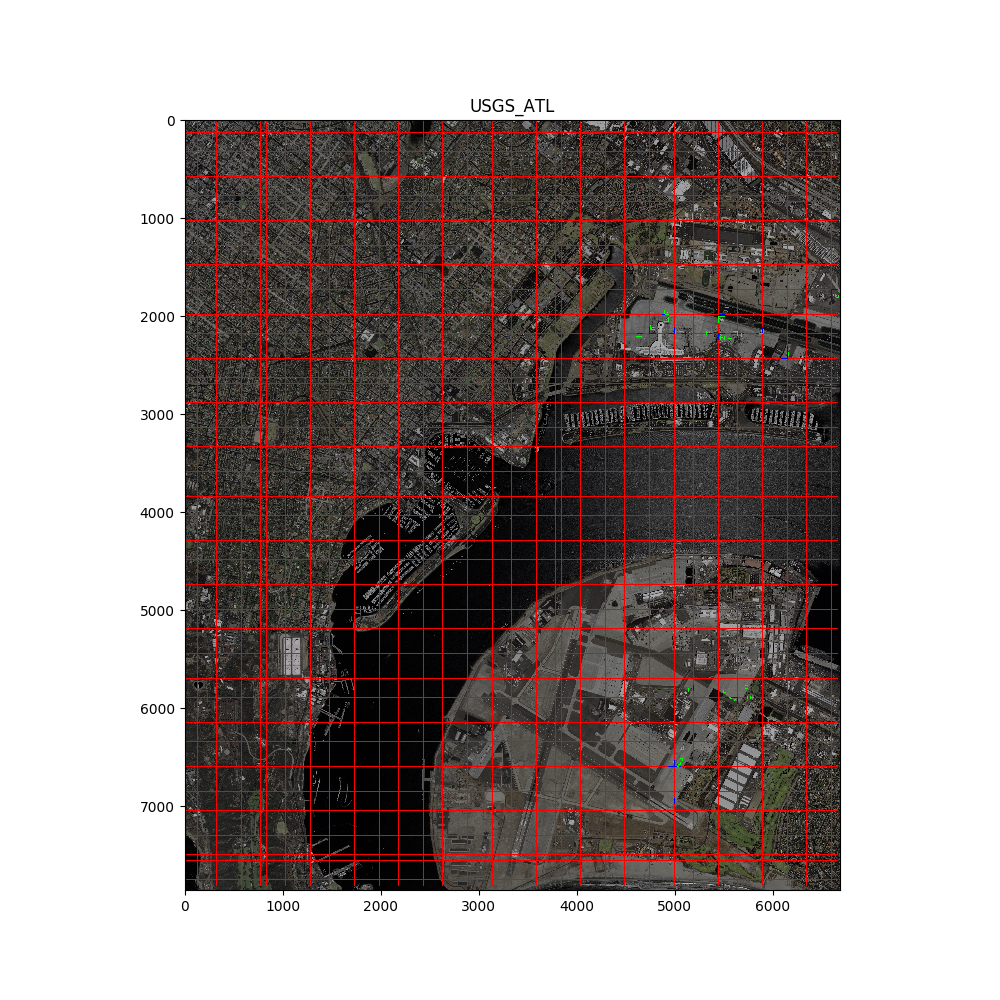

In [15]:
image = visualisation.draw_bboxes_on_image(image, background_tiles, color=(255,0,0))
image = visualisation.draw_bboxes_on_image(image, aircrafts_tiles, color=(0,0,255))
image = visualisation.draw_bboxes_on_image(image, labels, color=(0,255,0))

plt.figure(figsize=(10,10))
plt.title(item.image_id)
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


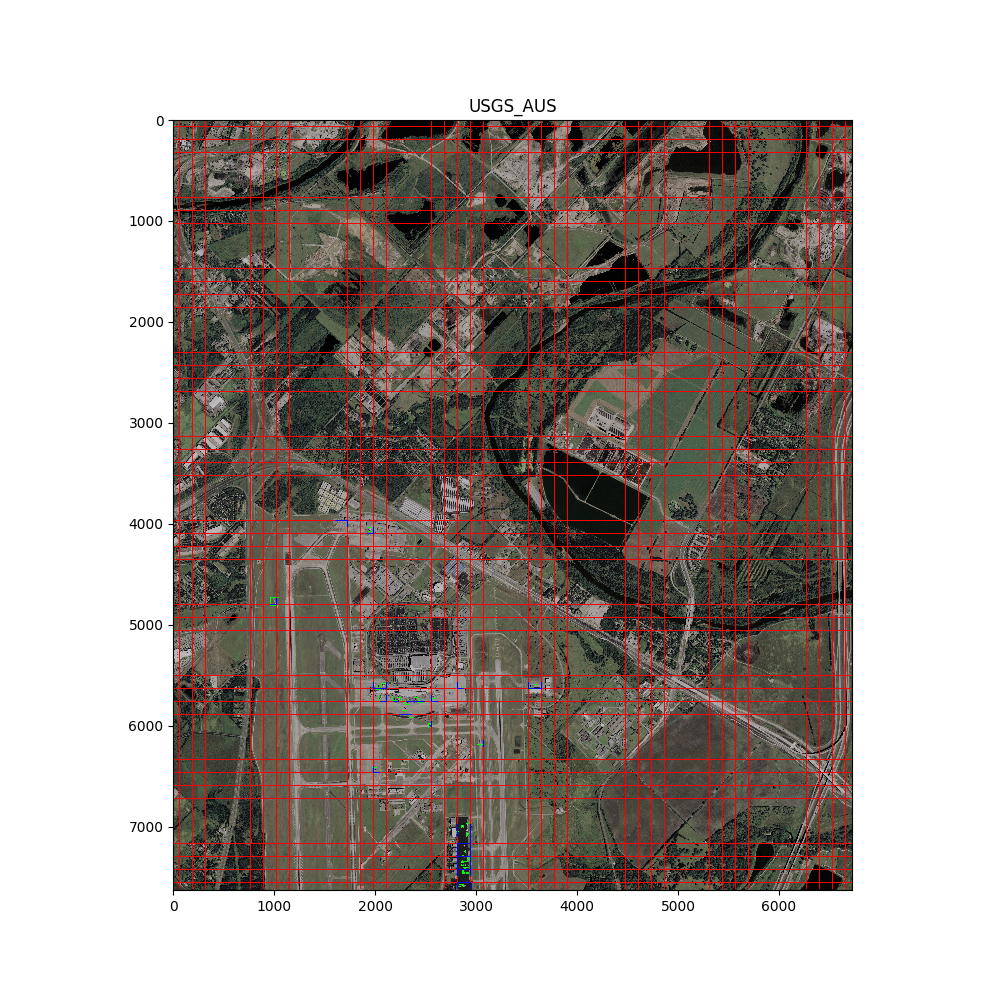

In [16]:
# A demo with higher level functions in the framework
item = dataset.items[1]
tiles = dataset.candidate_tiles

image = visualisation.draw_item_with_tiles(item, tiles)
plt.figure(figsize=(10,10))
plt.title(item.image_id)
plt.imshow(image)
plt.show()

## Apply a sampler to select tiles among candidates

In [17]:
# Random sampling of 4000 tiles from our dataset
sampler = RandomSampler(nb_tiles_max=4000, with_replacement=False)
dataset.sample_tiles_from_candidates(tiles_samplers=sampler)
print(dataset)

[2018-11-12 16:40:27,464][tp-isae][dataset][INFO] Sampling tiles


[2018-11-12 16:40:27,498][tp-isae][sampler][INFO] Sampling

[2018-11-12 16:40:27,517][tp-isae][dataset][INFO] Tiles sampled, now generate the dataset using Dataset.generate_tiles_dataset
--- TilesDataset ---
Found labels ['aircraft', 'background']
- Sliding windows:
{
    "class": "SlidingWindow",
    "tile_size": 64,
    "stride": 64,
    "padding": 0,
    "label_assignment_mode": "center",
    "ioa_threshold": 0.5,
    "discard_background": false,
    "data_transform_fn": null
}

- Samplers:
{
    "class": "RandomSampler",
    "with_replacement": false,
    "shuffle": true,
    "nb_tiles_max": 4000,
    "target_label": null
}

- Candidate tiles:
Item USGS_ATL: 12688 rois
Item USGS_ATL: Label aircraft: 30 rois
Item USGS_ATL: Label background: 12658 rois
Item USGS_AUS: 12495 rois
Item USGS_AUS: Label aircraft: 38 rois
Item USGS_AUS: Label background: 12457 rois

- Sampled tiles:
Item USGS_ATL: 1983 rois
Item USGS_ATL: Label aircraft: 4 rois
Item USGS_ATL: Label background: 1979 rois
It

<IPython.core.display.Javascript object>


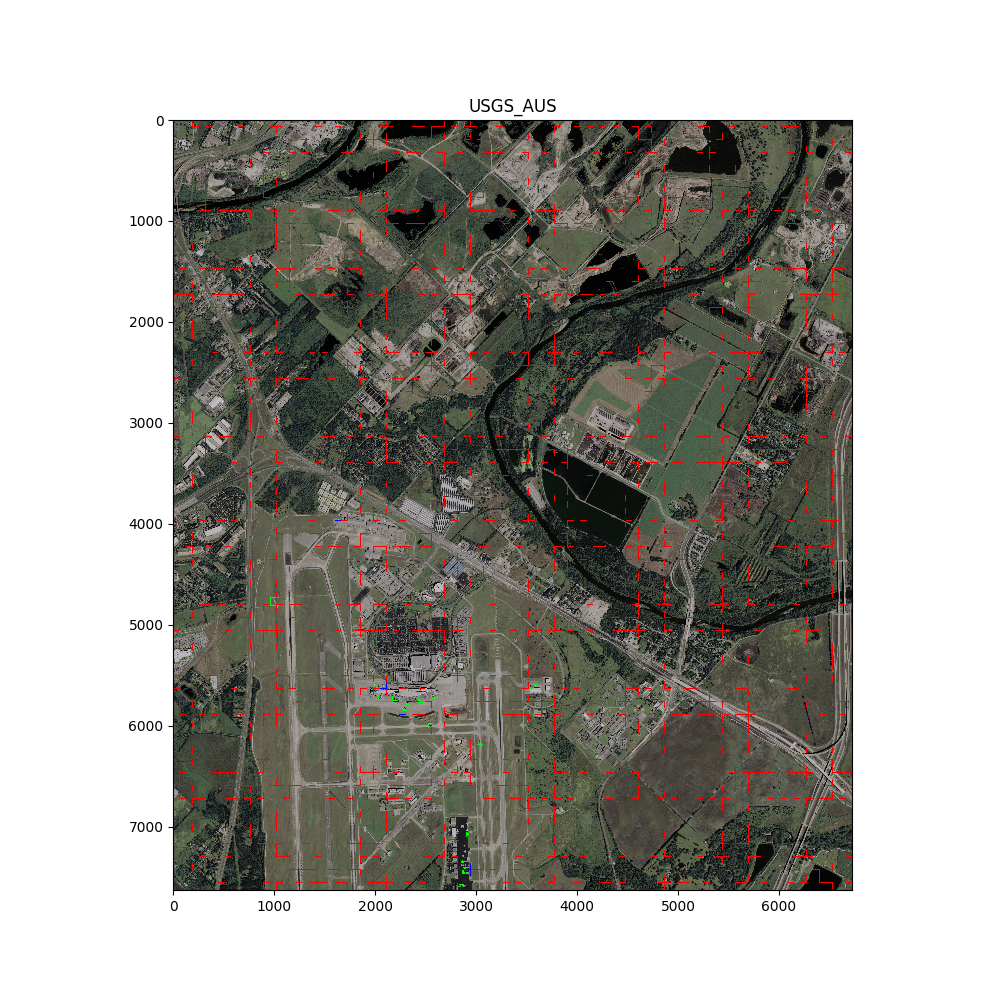

In [18]:
# A demo with higher level functions in the framework
item = dataset.items[1]
tiles = dataset.sampled_tiles

image = visualisation.draw_item_with_tiles(item, tiles)
plt.figure(figsize=(10,10))
plt.title(item.image_id)
plt.imshow(image)
plt.show()

## Dumping data

Once you have selected the correct sampling methodology,

In [19]:
# Now dump data to keras.ImageDataGenerator format

dataset_dir = os.path.join(os.path.expandvars("$TP_ISAE_DATA"), "dataset")

## Uncomment to dump
# dataset.generate_tiles_dataset(output_dir=dataset_dir,remove_first=True)